![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [54]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [55]:
bikes.shape

(10886, 12)

In [56]:
# Celda 1.1

# Análisis descriptivo de 'season' tomando 'total'
season_total_stats = bikes.groupby('season')['total'].describe()
season_total_stats

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


**Análisis de la variable 'season' a partir de la variable 'total'**

La variable 'season' representa las estaciones del año y se ha analizado en relación con la variable 'total', que representa alguna métrica (posiblemente el número total de bicicletas alquiladas) en un conjunto de datos.

1. En general, se observa que el número total de bicicletas alquiladas ('total') varía significativamente entre las estaciones del año.
2. Se observa que la desviación estándar es más alta para las temporadas 2 y 3 en comparación con las temporadas 1 y 4. Esto sugiere que la variabilidad en la cantidad de bicicletas alquiladas es mayor en las temporadas 2 y 3.
3. La mayor cantidad promedio de bicicletas alquiladas se observa en la estación 3, seguida de la estación 2.
4. La menor cantidad promedio de bicicletas alquiladas se observa en la estación 1.


In [57]:
# Celda 1.2
hour_total_stats = bikes.groupby('hour')['total'].describe()
hour_total_stats

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


**Análisis del resultado del método describe para la variable 'hour' a partir de la variable 'total':**

El análisis descriptivo proporciona información detallada sobre la relación entre la variable 'hour' (hora del día) y la variable 'total' (cantidad de bicicletas alquiladas). A continuación, se presentan las principales observaciones:

1. **Recuento (count):** Se observa que hay un recuento constante de observaciones para cada hora del día, con un total de 456 observaciones para cada hora. Esto indica que se tienen datos completos para cada hora del día.

2. **Media (mean):** La media de la variable 'total' varía significativamente según la hora del día. Por ejemplo, la cantidad promedio de bicicletas alquiladas a las 0 horas es de aproximadamente 55.14, mientras que a las 8 horas es de aproximadamente 362.77. Esto sugiere que la demanda de bicicletas varía a lo largo del día, con picos en ciertas horas.

3. **Desviación estándar (std):** Se observa que la desviación estándar es más alta para horas con mayores promedios, como a las 8 horas, lo que sugiere una mayor variabilidad en la cantidad de bicicletas alquiladas en esas horas.

4. **Valores mínimo y máximo (min y max):** Se observa que el número mínimo de bicicletas alquiladas varía entre las diferentes horas del día, al igual que el número máximo. Por ejemplo, el mínimo va desde 2 a las 0 horas hasta 977 a las 18 horas. Esto indica que la demanda de bicicletas varía considerablemente a lo largo del día aumentando en las horas finales de la tarde.




### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

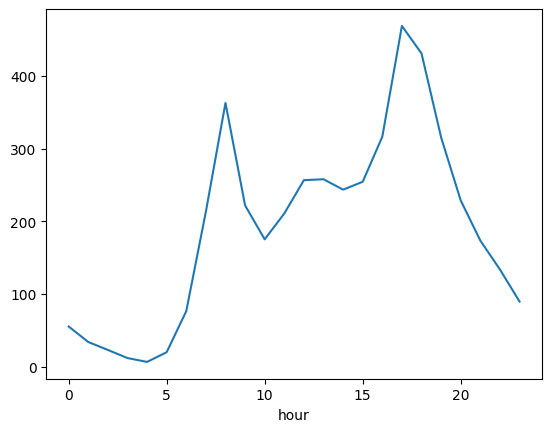

In [58]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

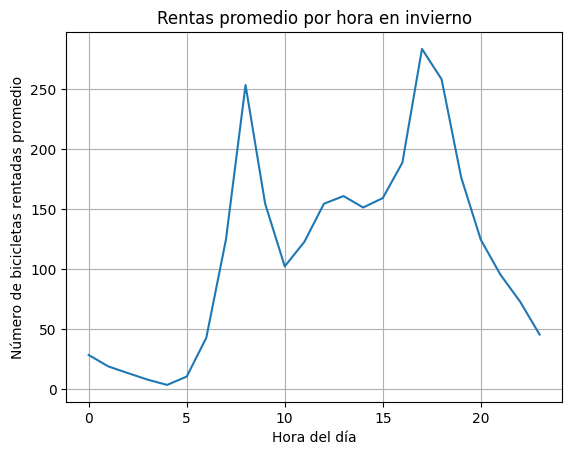

In [59]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 

#Gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" en invierno (season = 1)
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot()
plt.title('Rentas promedio por hora en invierno')
plt.xlabel('Hora del día')
plt.ylabel('Número de bicicletas rentadas promedio')
plt.grid(True)
plt.show()


**Hallazgos**:
El gráfico muestra la variación del número promedio de bicicletas rentadas por hora durante la temporada de invierno. Se observa que la demanda de bicicletas presenta un patrón similar al gráfico general, con picos en horas pico como por la mañana y al final de la tarde. Sin embargo, es probable que haya diferencias en la magnitud de la demanda en comparación con otras estaciones debido a las condiciones climáticas y las preferencias estacionales de los usuarios.

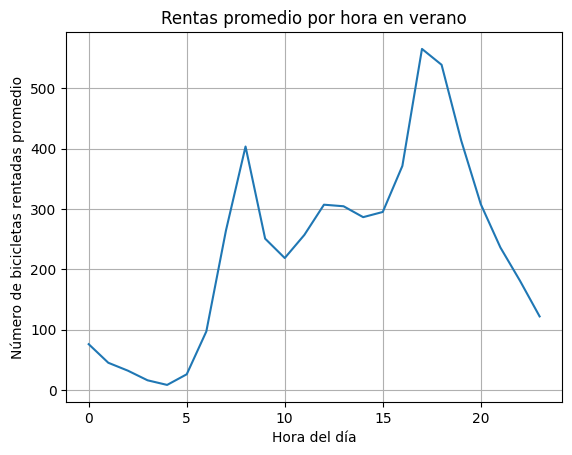

In [60]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
# Gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" en verano (season = 3)
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot()
plt.title('Rentas promedio por hora en verano')
plt.xlabel('Hora del día')
plt.ylabel('Número de bicicletas rentadas promedio')
plt.grid(True)
plt.show()



**Hallazgos**:
El gráfico muestra la variación del número promedio de bicicletas rentadas por hora durante la temporada de verano. Se observa un patrón similar al gráfico general y al de invierno, con picos en horas pico durante el día y una disminución en la noche. Esto sugiere que, independientemente de la temporada, la demanda de bicicletas sigue un patrón diario consistente, aunque la magnitud de la demanda puede variar debido a las condiciones climáticas y otros factores estacionales.

*Retroalimentación*

No se comparan las magnitudes del comportamiento de los alquileres para ambas temporadas, solo se habla del patrón.

Con respecto a esta parte del texto: " aunque la magnitud de la demanda puede variar debido a las condiciones climáticas y otros factores estacionales. ", la magnitud efectivamente varía y se nota que es mayor en verano.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [61]:
# Celda 3
# Ajuste de un modelo de regresión lineal

# Convertir la variable "season" en variables dummy
bikes_with_dummies = pd.get_dummies(bikes, columns=['season'], drop_first=True)

# Definir las variables predictoras y la variable de respuesta
X = bikes_with_dummies[['hour', 'season_2', 'season_3', 'season_4']]
y = bikes_with_dummies['total']

# Añadir intercepto
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal
model = sm.OLS(y, X).fit()

# Imprimir los coeficientes
print(model.summary())

# Calcular las predicciones del modelo
y_pred = model.predict(X)

# Calcular el MSE
mse = mean_squared_error(y, y_pred)

# Imprimir el MSE
print("MSE del modelo de regresión lineal:", mse)


                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     782.5
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:34:31   Log-Likelihood:                -70669.
No. Observations:               10886   AIC:                         1.413e+05
Df Residuals:                   10881   BIC:                         1.414e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4303      4.016     -1.601      0.1

### Análisis de Coeficientes del Modelo de Regresión Lineal

El modelo de regresión lineal ajustado tiene la siguiente forma:


$
\text{total} = -6.4303 + 10.5452 \times \text{hour} + 100.3172 \times \text{season\_2} + 119.4675 \times \text{season\_3} + 84.0831 \times \text{season\_4}
$


#### Coeficientes:

- **Intercepto (const):** El coeficiente asociado al intercepto es -6.4303. Esto significa que cuando todas las variables predictoras (hora y temporada) son iguales a cero, el número total de bicicletas rentadas sería de aproximadamente -6.4303. Sin embargo, en este contexto, esta interpretación puede no tener un significado práctico, ya que la hora y la temporada no pueden ser cero en la realidad.

- **Hora (hour):** El coeficiente para la variable "hour" es 10.5452. Esto indica que, manteniendo constantes las variables de temporada, se espera un aumento de aproximadamente 10.5452 bicicletas rentadas por cada unidad de incremento en la hora del día.

- **Temporada 2 (season_2):** El coeficiente para la variable "season_2" es 100.3172. Esto indica que, en comparación con la temporada de referencia (temporada 1), se espera que el número total de bicicletas rentadas aumente en aproximadamente 100.3172 unidades durante la temporada 2.

- **Temporada 3 (season_3):** El coeficiente para la variable "season_3" es 119.4675. Esto indica que, en comparación con la temporada de referencia (temporada 1), se espera que el número total de bicicletas rentadas aumente en aproximadamente 119.4675 unidades durante la temporada 3.

- **Temporada 4 (season_4):** El coeficiente para la variable "season_4" es 84.0831. Esto indica que, en comparación con la temporada de referencia (temporada 1), se espera que el número total de bicicletas rentadas aumente en aproximadamente 84.0831 unidades durante la temporada 4.

**Interpretación General**:

El modelo sugiere que tanto la hora del día como la temporada tienen un impacto significativo en el número total de bicicletas rentadas. A medida que la hora del día aumenta, se espera que la demanda de bicicletas aumente, lo que es coherente con la intuición de que más personas rentan bicicletas durante las horas pico. Además, las diferentes estaciones tienen diferentes niveles de demanda de bicicletas, lo que se refleja en los coeficientes positivos asociados con las variables de temporada. 

Sin embargo, es importante tener en cuenta las limitaciones de la regresión lineal en este caso, como las suposiciones de linealidad y aditividad, la independencia de errores y la homocedasticidad, que podrían no cumplirse completamente en este contexto de datos de series temporales.

##### **Limitaciones de la regresión lineal en este caso**:

**Supuestos de linealidad y aditividad**: La regresión lineal asume que la relación entre las variables predictoras y la variable de respuesta es lineal y aditiva. Esto podría no ser el caso en situaciones donde la relación es más compleja o no lineal, como podría ser el caso en la demanda de bicicletas que puede tener patrones estacionales no lineales.

**Independencia de errores**: La regresión lineal asume que los errores están independientemente distribuidos. Sin embargo, en este caso, los errores pueden estar correlacionados en el tiempo debido a la naturaleza secuencial de los datos de series temporales.

**Homocedasticidad**: La regresión lineal también asume homocedasticidad, lo que significa que la variabilidad de los errores es constante en todos los niveles de las variables predictoras. Sin embargo, en este caso, la variabilidad de la demanda de bicicletas puede variar a lo largo del día y entre estaciones, lo que podría violar este supuesto.

**Normalidad de errores**: La regresión lineal supone que los errores se distribuyen normalmente. Esta suposición puede no ser válida en este caso si la distribución de los errores no es normal debido a la presencia de valores atípicos o a la distribución sesgada de la variable de respuesta.

En resumen, mientras que la regresión lineal puede proporcionar información útil sobre la relación entre las variables predictoras y la variable de respuesta, su aplicación en este caso puede verse limitada por la complejidad de la relación subyacente y por las violaciones de los supuestos de regresión lineal.

*Retroalimentación*:
Hay errores en la interpretación de los coeficientes. Se indica en la sección de la constante que: "Sin embargo, en este contexto, esta interpretación puede no tener un significado práctico, ya que la hora y la temporada no pueden ser cero en la realidad. "

Esto es falso ya que en la data hay horas cero (medianoche), y además como se estan utilizando variables binarias en las temporadas estas también pueden tomar el valor de cero.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [62]:
# Celda 4
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)


# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_


# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definir las variables predictoras y la variable de respuesta
X = bikes[['hour', 'season']]
y = bikes['total']

# Crear el árbol de decisiones
tree = tree_grow(X, y, max_depth=6)


# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacío, solo continúa con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # Si el nodo derecho está vacío, solo continúa con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Ejecución de función tree_predict
tree_predict(X, tree)


array([1., 1., 1., ..., 1., 1., 1.])

*Retroalimentación*:
No se utiliza una metrica de regresión para hacer las separaciones del árbol (se usa el Gini que es de clasificación), además se están haciendo predicciones binarias en un problema de regresión.

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [63]:
# Celda 5
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(bikes[['season', 'hour']], bikes['total'], test_size=0.2, random_state=42)

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
mse_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeRegressor de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Mejor MSE (desempeño del modelo) y su correspondiente max_depth
best_mse, best_max_depth = min(zip(mse_scores, max_depth_range))

# Imprimir el mejor MSE y su correspondiente max_depth
print(f"Mejor MSE: {best_mse}, Max Depth: {best_max_depth}")

# max_depth=best_max_depth fue el mejor, se ajusta un árbol usando este valor 
best_clf = DecisionTreeRegressor(max_depth=best_max_depth, random_state=1)
best_clf.fit(X_train, y_train)

"""En este código, dividimos los datos en conjuntos de entrenamiento y prueba, luego iteramos sobre diferentes valores de max_depth para encontrar el que minimiza el error cuadrático medio (MSE). Finalmente, ajustamos un árbol de decisiones usando el mejor valor encontrado para max_depth."""

Mejor MSE: 13451.363196184311, Max Depth: 9


'En este código, dividimos los datos en conjuntos de entrenamiento y prueba, luego iteramos sobre diferentes valores de max_depth para encontrar el que minimiza el error cuadrático medio (MSE). Finalmente, ajustamos un árbol de decisiones usando el mejor valor encontrado para max_depth.'

##### **Análisis Comparativo del Mejor Modelo**

El modelo de árbol de decisiones tiene un MSE significativamente menor que el modelo de regresión lineal, con valores de 13451.36 y 25480.69, respectivamente. Esto sugiere que el modelo de árbol de decisiones tiene un mejor rendimiento en términos de precisión de predicción en este conjunto de datos específico.

La diferencia en el MSE entre los dos modelos sugiere que el modelo de árbol de decisiones es más efectivo para capturar la relación entre las variables predictoras y la variable objetivo "total". Esto puede deberse a la capacidad del árbol de decisiones para capturar relaciones no lineales y complejas entre las variables.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [64]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [65]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [66]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [67]:
# Celda 6
# Árbol de decisión
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=1)
tree_clf.fit(X_train, y_train)
tree_pred = tree_clf.predict(X_test)

# Regresión logística
log_reg = LogisticRegression(random_state=1)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)

# Evaluación del desempeño
tree_accuracy = accuracy_score(y_test, tree_pred)
tree_f1 = f1_score(y_test, tree_pred)

log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
log_reg_f1 = f1_score(y_test, log_reg_pred)

print("Desempeño del Árbol de Decisión:")
print("Accuracy:", tree_accuracy)
print("F1-Score:", tree_f1)

print("\nDesempeño de la Regresión Logística:")
print("Accuracy:", log_reg_accuracy)
print("F1-Score:", log_reg_f1)

Desempeño del Árbol de Decisión:
Accuracy: 0.6373333333333333
F1-Score: 0.6616915422885573

Desempeño de la Regresión Logística:
Accuracy: 0.6126666666666667
F1-Score: 0.6092804303967719


*Retroalimentación*
No calibra ningún hiperparámetro del árbol ni compara los resultados de ambos modelos. Siempre que se calcule una métrica de desempeño se debe comentar acerca de esta.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [68]:
# Celda 7
# Árboles de decisión con diferentes parámetros
tree_max_depth = DecisionTreeClassifier(max_depth=5, random_state=1)
tree_min_samples_leaf = DecisionTreeClassifier(min_samples_leaf=5, random_state=1)

# Regresión logística
log_reg = LogisticRegression(random_state=1)

# Bagging de cada modelo
bagged_tree_max_depth = BaggingClassifier(base_estimator=tree_max_depth, n_estimators=100, random_state=1)
bagged_tree_min_samples_leaf = BaggingClassifier(base_estimator=tree_min_samples_leaf, n_estimators=100, random_state=1)
bagged_log_reg = BaggingClassifier(base_estimator=log_reg, n_estimators=100, random_state=1)

# Votación mayoritaria
voting_clf = VotingClassifier(estimators=[('tree_max_depth', bagged_tree_max_depth),
                                          ('tree_min_samples_leaf', bagged_tree_min_samples_leaf),
                                          ('log_reg', bagged_log_reg)],
                               voting='hard')

# Entrenamiento y evaluación de modelos individuales
models = [bagged_tree_max_depth, bagged_tree_min_samples_leaf, bagged_log_reg]
model_names = ['Árbol (max_depth)', 'Árbol (min_samples_leaf)', 'Regresión Logística']

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1-Score: {f1}")
    print()

# Entrenamiento y evaluación del ensamble
voting_clf.fit(X_train, y_train)
y_pred_ensemble = voting_clf.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)

print("Ensamble de Modelos (Votación Mayoritaria):")
print(f"Accuracy: {accuracy_ensemble}")
print(f"F1-Score: {f1_ensemble}")


Árbol (max_depth):
Accuracy: 0.66
F1-Score: 0.6599999999999999

Árbol (min_samples_leaf):
Accuracy: 0.6446666666666667
F1-Score: 0.6458471760797342

Regresión Logística:
Accuracy: 0.6213333333333333
F1-Score: 0.6167341430499326

Ensamble de Modelos (Votación Mayoritaria):
Accuracy: 0.658
F1-Score: 0.6595885865958858


*Retroalimentación*
La lógica del ensamble es incorrecta, se está haciendo el bagging de los 3 modelos pero despues el voting classifier va sobre las decisiones de esos 3 modelos ya ensamblados. Está pasando el ejemplo que David justo explicó en Slack que hay que tener cuidado, ya que se está haciendo votación mayoritaria de modelos donde ya se hizo la totalización por separado.


Además de esto, no se comenta de la comparación de las métricas de desempeño.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [69]:
# Celda 8
# Árboles de decisión con diferentes parámetros
tree_max_depth = DecisionTreeClassifier(max_depth=5, random_state=1)
tree_min_samples_leaf = DecisionTreeClassifier(min_samples_leaf=5, random_state=1)

# Regresión logística
log_reg = LogisticRegression(random_state=1)

# Bagging de cada modelo
bagged_tree_max_depth = BaggingClassifier(base_estimator=tree_max_depth, n_estimators=100, random_state=1)
bagged_tree_min_samples_leaf = BaggingClassifier(base_estimator=tree_min_samples_leaf, n_estimators=100, random_state=1)
bagged_log_reg = BaggingClassifier(base_estimator=log_reg, n_estimators=100, random_state=1)

# Votación ponderada con pesos arbitrarios
voting_clf_weighted = VotingClassifier(estimators=[('tree_max_depth', bagged_tree_max_depth),
                                          ('tree_min_samples_leaf', bagged_tree_min_samples_leaf),
                                          ('log_reg', bagged_log_reg)],
                               voting='soft',
                               weights=[2, 1, 1])

# Entrenamiento y evaluación de modelos individuales
models = [bagged_tree_max_depth, bagged_tree_min_samples_leaf, bagged_log_reg]
model_names = ['Árbol (max_depth)', 'Árbol (min_samples_leaf)', 'Regresión Logística']

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1-Score: {f1}")
    print()

# Entrenamiento y evaluación del ensamble ponderado
voting_clf_weighted.fit(X_train, y_train)
y_pred_weighted = voting_clf_weighted.predict(X_test)
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
f1_weighted = f1_score(y_test, y_pred_weighted)

print("Ensamble de Modelos (Votación Ponderada):")
print(f"Accuracy: {accuracy_weighted}")
print(f"F1-Score: {f1_weighted}")

Árbol (max_depth):
Accuracy: 0.66
F1-Score: 0.6599999999999999

Árbol (min_samples_leaf):
Accuracy: 0.6446666666666667
F1-Score: 0.6458471760797342

Regresión Logística:
Accuracy: 0.6213333333333333
F1-Score: 0.6167341430499326

Ensamble de Modelos (Votación Ponderada):
Accuracy: 0.654
F1-Score: 0.6569729015201586


*Retroalimentación*
En este caso el soft voting si funciona para lo requerido pero de nuevo no se compara la efectividad de los modelos a través de las métricas de desempeño

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

- **Votación Ponderada:**
  - Accuracy: 0.654
  - F1-Score: 0.657

- **Votación Mayoritaria:**
  - Accuracy: 0.658
  - F1-Score: 0.660

Al comparar los resultados obtenidos con las metodologías utilizadas en los puntos 7 y 8, es importante considerar varios aspectos:

1. **Votación Mayoritaria:**
   - **Ventajas:**
     - Es sencillo de implementar y entender.
     - La decisión se toma por mayoría, lo que puede ser robusto frente a errores individuales en los modelos base.
   - **Desventajas:**
     - No considera la confianza o la calidad de las predicciones de los modelos base.
     - No pondera adecuadamente la contribución de cada modelo base en la decisión final.

2. **Votación Ponderada:**
   - **Ventajas:**
     - Permite asignar pesos diferentes a los modelos base según su rendimiento o confianza.
     - Considera la calidad de las predicciones al ponderarlas.
   - **Desventajas:**
     - Requiere calibrar los pesos de manera adecuada, lo que puede ser complejo.
     - Puede ser sensible a sobreajuste si los pesos se ajustan en exceso sobre el conjunto de entrenamiento.

En cuanto a los resultados obtenidos, vemos que ambos métodos produjeron resultados similares en términos de Accuracy y F1-Score. Sin embargo, el modelo de votación mayoritaria tuvo un rendimiento ligeramente mejor en ambas métricas en comparación con el modelo de votación ponderada en el caso específico de este conjunto de datos.

En resumen, la elección entre votación mayoritaria y votación ponderada depende de varios factores, como la complejidad del problema, la calidad de los modelos base y la disponibilidad de recursos para calibrar los pesos en el caso de votación ponderada. En este caso particular, la votación mayoritaria fue suficiente y tuvo un rendimiento comparable al de la votación ponderada. Sin embargo, en otros escenarios, la votación ponderada podría ser preferible si se necesita una mayor flexibilidad en la asignación de pesos a los modelos base.